# Mall Customer Segmentation Notebook

# Setup

In [51]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_csv('Mall_Customers.csv')

In [53]:
# Quick overview
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Univariate EDA



Descriptive stats (min, median, max):
     CustomerID   Age  Annual Income (k$)  Spending Score (1-100)
min         1.0  18.0                15.0                     1.0
50%       100.5  36.0                61.5                    50.0
max       200.0  70.0               137.0                    99.0


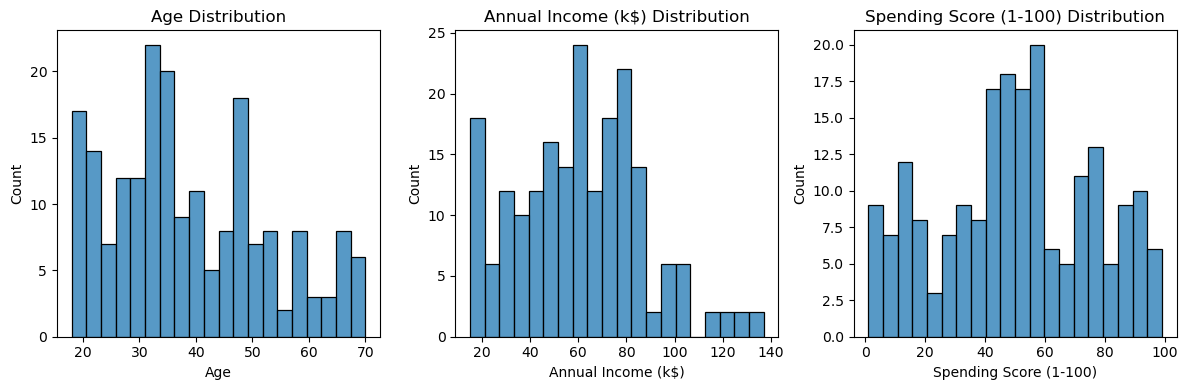

In [56]:
# Descriptive stats (min, median, max)
stats = df.describe().loc[['min','50%','max']]
print("Descriptive stats (min, median, max):")
print(stats)

# Histograms in one figure
features = ['Age','Annual Income (k$)','Spending Score (1-100)']
plt.figure(figsize=(12,4))
for i, col in enumerate(features, 1):
    plt.subplot(1,3,i)
    sns.histplot(df[col], bins=20)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Insight: All features show broad coverage with no extreme outliers

## Bivariate EDA

In [ ]:
# Encode Gender
df['GenderCode'] = df['Gender'].map({'Male':0,'Female':1})


### 3.1 Income vs Spending Score by Gender


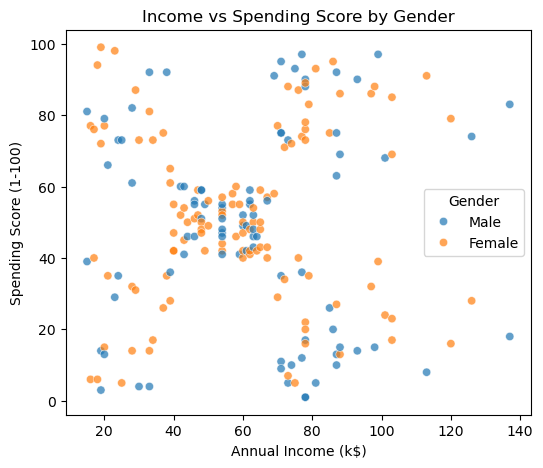

In [60]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='Gender', data=df, palette='tab10', alpha=0.7
)
plt.title('Income vs Spending Score by Gender')
plt.show()
# Insight: Income weakly correlated with spending; females slightly higher scores

### 3.2 Average Spending Score by Income Bin


In [63]:
bins = [0,30,60,90,120,150]
df['IncomeBin'] = pd.cut(df['Annual Income (k$)'], bins)
avg_spend = df.groupby('IncomeBin', observed=True)['Spending Score (1-100)'].mean().reset_index()
print("Average Spending Score by Income Bin:")
print(avg_spend)

Average Spending Score by Income Bin:
    IncomeBin  Spending Score (1-100)
0     (0, 30]               49.656250
1    (30, 60]               50.196970
2    (60, 90]               49.925000
3   (90, 120]               52.277778
4  (120, 150]               50.750000


### 3.3 Correlation Matrix

In [68]:
corr = df[['Age','Annual Income (k$)','Spending Score (1-100)']].corr()
print("Correlation matrix:")
print(corr)

Correlation matrix:
                             Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


## 4. Feature Preparation


In [73]:
features_cluster = ['Age','Annual Income (k$)','Spending Score (1-100)']
X = df[features_cluster]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Clustering

C:\Users\drxt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\drxt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\drxt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\drxt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

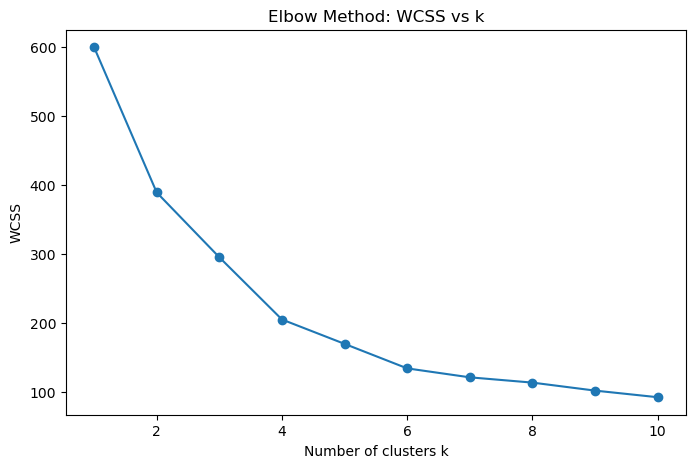

In [76]:
# Elbow Method
distortions = []
for k in range(1,11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    distortions.append(km.inertia_)
plt.figure(figsize=(8,5))
plt.plot(range(1,11), distortions, marker='o')
plt.title('Elbow Method: WCSS vs k')
plt.xlabel('Number of clusters k')
plt.ylabel('WCSS')
plt.show()

### Fit K-Means with k=5

In [92]:

k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\drxt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Cluster centers (original scale)

In [95]:
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features_cluster)
print("Cluster centers (original scale):")
print(centers)

Cluster centers (original scale):
         Age  Annual Income (k$)  Spending Score (1-100)
0  55.275862           47.620690               41.706897
1  32.875000           86.100000               81.525000
2  25.769231           26.115385               74.846154
3  26.733333           54.311111               40.911111
4  44.387097           89.774194               18.483871


# 6. Results & Cluster Profiling

### Numeric feature means by cluster


In [99]:
cluster_feature_means = df.groupby('Cluster')[features_cluster].mean()
print("Cluster feature means:")
print(cluster_feature_means)

Cluster feature means:
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        55.275862           47.620690               41.706897
1        32.875000           86.100000               81.525000
2        25.769231           26.115385               74.846154
3        26.733333           54.311111               40.911111
4        44.387097           89.774194               18.483871


### Gender distribution by cluster (%)


In [102]:
cluster_gender_pct = (
    df.groupby('Cluster')['Gender']
      .value_counts(normalize=True)
      .mul(100)
      .rename('Pct')
      .reset_index()
)
print("Gender distribution by cluster (%):")
print(cluster_gender_pct)

Gender distribution by cluster (%):
   Cluster  Gender        Pct
0        0  Female  56.896552
1        0    Male  43.103448
2        1  Female  55.000000
3        1    Male  45.000000
4        2  Female  57.692308
5        2    Male  42.307692
6        3  Female  60.000000
7        3    Male  40.000000
8        4    Male  51.612903
9        4  Female  48.387097


### Map cluster names for readability

In [105]:
cluster_names = {
    0: "Mature Low‑Spenders",
    1: "Affluent High‑Spenders",
    2: "Young Value Seekers",
    3: "Youthful Moderate‑Spenders",
    4: "Wealthy Cautious‑Spenders"
}
df['Segment'] = df['Cluster'].map(cluster_names)

# Final scatterplot with segment names

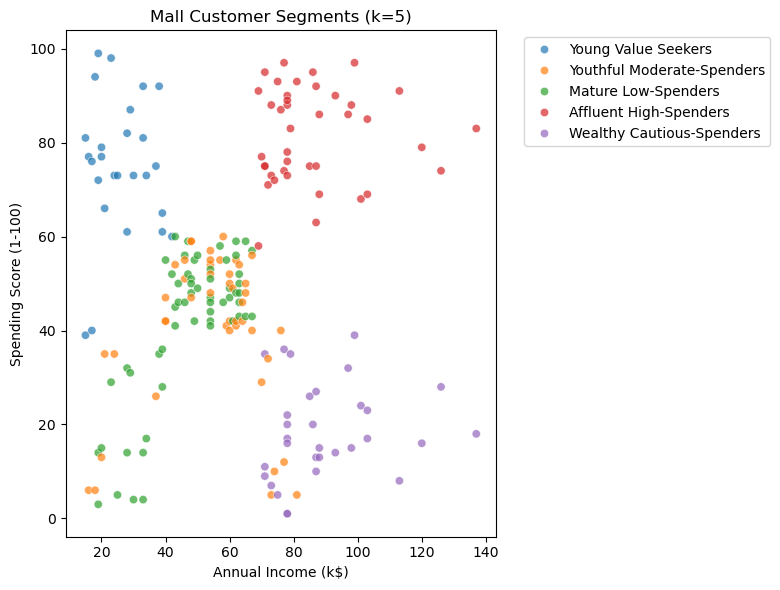

In [108]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='Segment', data=df, palette='tab10', alpha=0.7
)
plt.title('Mall Customer Segments (k=5)')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
